In [5]:
import os
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import MaxPooling2D
from pathlib import Path
import numpy as np
import tensorflow as tf
import h5py as h5py
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 32

train_generator = ImageDataGenerator(validation_split=0.2,
                                     rescale=1./255,
                                     preprocessing_function=preprocess_input)

test_generator = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function=preprocess_input)

dataset:https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images

In [7]:
download_dir = Path('')

In [8]:
img_width, img_height = 128, 128

In [10]:
train_data_dir = download_dir/'train'
test_data_dir = download_dir/'test'

class_subset = sorted(os.listdir(download_dir/'train'))
print(class_subset)
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(img_height, img_width),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=20)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(img_height, img_width),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=20)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(img_height, img_width),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Found 4121 images belonging to 4 classes.
Found 1029 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


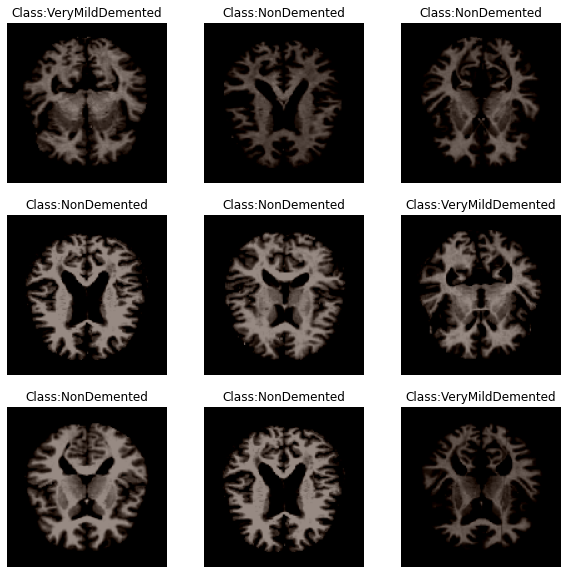

In [29]:
def show_images(generator,y_pred=None):
  
    labels =dict(zip([0,1,2,3], class_subset))
    x,y = generator.next()

    # show a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = np.random.randint(0,32)
            plt.imshow(x[idx], vmin=0, vmax=255)
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
show_images(traingen)

In [11]:
def create_model(input_shape, n_classes, optimizer, fine_tune=0):
    
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    print('Model loaded.')
    #initialize top model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=vgg_model.output_shape[1:]))
    top_model.add(Dense(256))
    top_model.add(BatchNormalization())
    top_model.add(Activation('relu'))
    top_model.add(Dropout(0.2))
    top_model.add(Dense(n_classes, activation='softmax'))

    model = Model(inputs=vgg_model.input, outputs=top_model(vgg_model.output))

    model.trainable = True
    
    if fine_tune > 0:
        fine_tune = (fine_tune * 4) + 1   #fine tuning based number of blocks 
        for layer in model.layers[:-fine_tune]:
            print(layer.name)
            layer.trainable = False
    else:
        for layer in model.layers[:19]: #freez all convolution layers
            layer.trainable = False   

    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall() ,tf.keras.metrics.AUC()])
    
    return model

# **Base Model**

In [14]:
input_shape = (128, 128, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=4

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

58889256/58889256 [==============================] - 3s 0us/step
Model loaded.


In [ ]:
print(vgg_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [13]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

plot_loss_1 = PlotLossesCallback()

# alz_checkpoint_1 = ModelCheckpoint(filepath='Alz_model_v1.best.hdf5',
#                                   save_best_only=True,
#                                   verbose=1)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           verbose = 1,
                          #  restore_best_weights=True,
                           mode='auto')

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

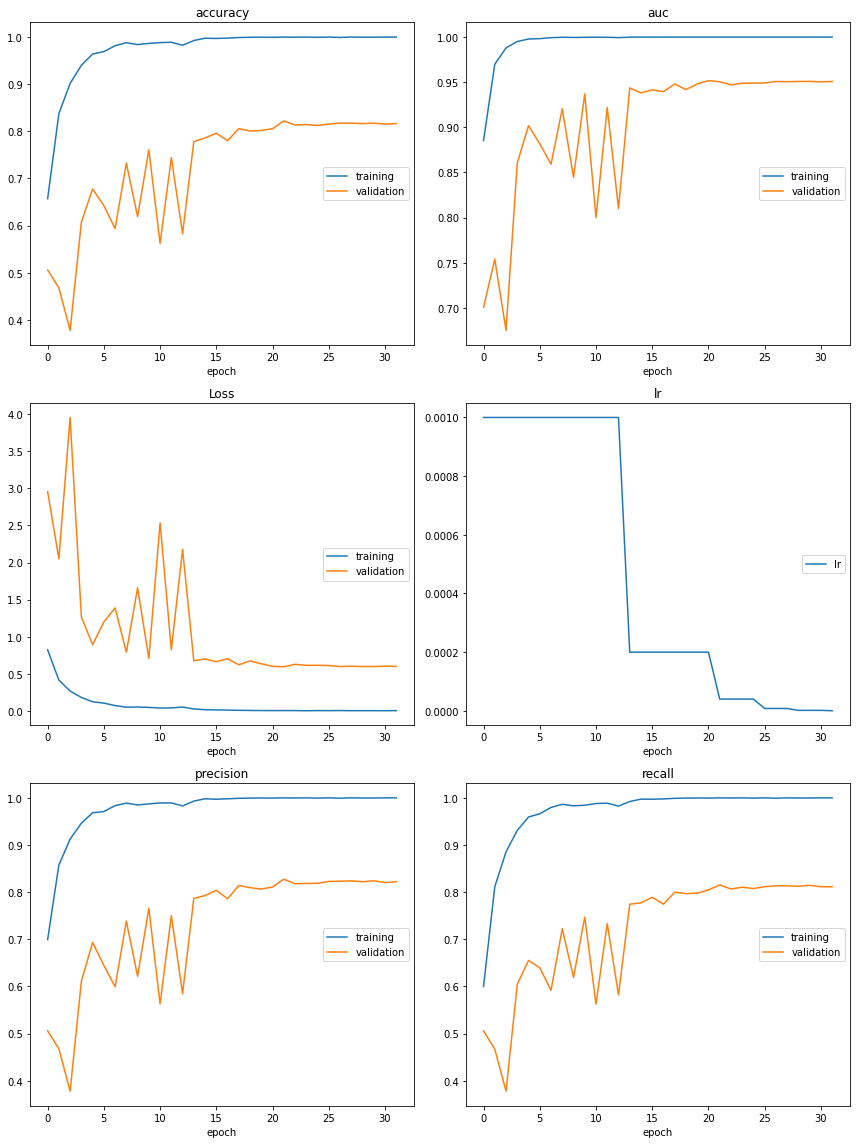

accuracy
	training         	 (min:    0.657, max:    1.000, cur:    1.000)
	validation       	 (min:    0.378, max:    0.822, cur:    0.816)
auc
	training         	 (min:    0.885, max:    1.000, cur:    1.000)
	validation       	 (min:    0.675, max:    0.952, cur:    0.951)
Loss
	training         	 (min:    0.003, max:    0.824, cur:    0.005)
	validation       	 (min:    0.596, max:    3.956, cur:    0.600)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
precision
	training         	 (min:    0.699, max:    1.000, cur:    1.000)
	validation       	 (min:    0.378, max:    0.828, cur:    0.822)
recall
	training         	 (min:    0.600, max:    1.000, cur:    1.000)
	validation       	 (min:    0.378, max:    0.815, cur:    0.812)
128/128 [==============================] - 13s 98ms/step - loss: 0.0046 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.6004 - val_accuracy: 0.8164 - val_precision: 0.8220 - val_recall: 0.8115 - val_a

In [ ]:
vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[early_stop, reduce_lr, plot_loss_1],
                            verbose=1)

In [23]:
#vgg_model.load_weights('Alz_model_v1.best.hdf5')

true_classes = testgen.classes
class_indices = traingen.class_indices
print(class_indices)
class_indices = dict((v,k) for k,v in class_indices.items())
print(class_indices)

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

{'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
{0: 'MildDemented', 1: 'ModerateDemented', 2: 'NonDemented', 3: 'VeryMildDemented'}


In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("Accuracy without Fine-Tuning and Augmentation: {:.2f}%".format(vgg_acc * 100))

Accuracy without Fine-Tuning and Augmentation: 50.82%


# **Model with Fine Tuning**

In [ ]:
traingen.reset()
validgen.reset()
testgen.reset()

train_generator = ImageDataGenerator(validation_split=0.2,
                                     rescale=1./255,
                                     preprocessing_function=preprocess_input)

test_generator = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function=preprocess_input)

In [ ]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(img_height, img_width),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=20)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(img_height, img_width),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=20)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(img_height, img_width),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False)

Found 4121 images belonging to 4 classes.
Found 1029 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


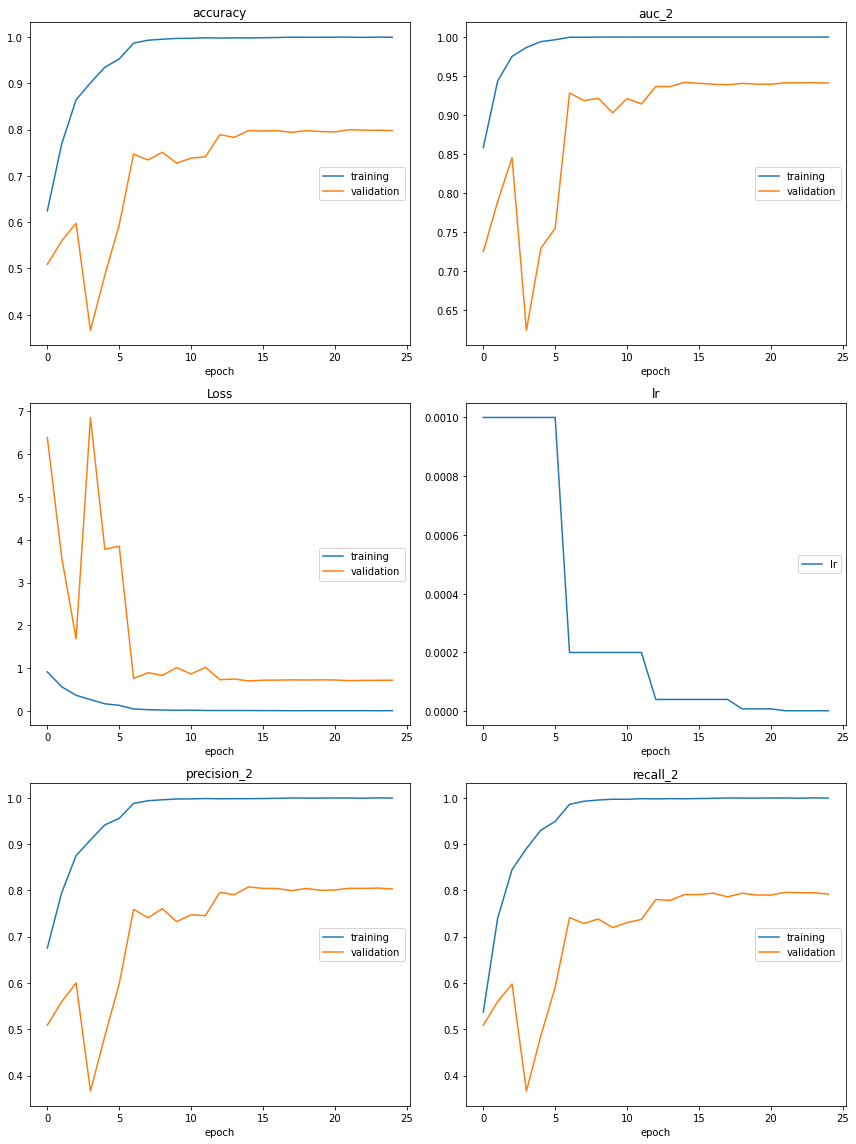

accuracy
	training         	 (min:    0.624, max:    1.000, cur:    1.000)
	validation       	 (min:    0.366, max:    0.800, cur:    0.798)
auc_2
	training         	 (min:    0.859, max:    1.000, cur:    1.000)
	validation       	 (min:    0.625, max:    0.942, cur:    0.941)
Loss
	training         	 (min:    0.005, max:    0.913, cur:    0.007)
	validation       	 (min:    0.702, max:    6.856, cur:    0.719)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
precision_2
	training         	 (min:    0.675, max:    1.000, cur:    1.000)
	validation       	 (min:    0.366, max:    0.808, cur:    0.803)
recall_2
	training         	 (min:    0.537, max:    1.000, cur:    1.000)
	validation       	 (min:    0.366, max:    0.796, cur:    0.792)
128/128 [==============================] - 13s 101ms/step - loss: 0.0071 - accuracy: 0.9995 - precision_2: 0.9995 - recall_2: 0.9995 - auc_2: 1.0000 - val_loss: 0.7190 - val_accuracy: 0.7979 - val_precision_2: 0.8030 - val_recall_

In [ ]:
optim_3 = Adam(lr=0.001)

vgg_model_finetuning = create_model(input_shape, n_classes, optim_3, fine_tune=1)

plot_loss_3 = PlotLossesCallback()

# alz_checkpoint_2 = ModelCheckpoint(filepath='Alz_model_v2.best.hdf5',
#                                   save_best_only=True,
#                                   verbose=1)

vgg_ft_history = vgg_model_finetuning.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[early_stop, reduce_lr, plot_loss_3],
                                  verbose=1)


In [ ]:
vgg_preds_finetuning = vgg_model_finetuning.predict(testgen)
vgg_pred_classes_finetuning = np.argmax(vgg_preds_finetuning, axis=1)

1279/1279 [==============================] - 7s 5ms/step


In [ ]:
vgg_acc_finetuning = accuracy_score(true_classes, vgg_pred_classes_finetuning)
print("Accuracy with Fine-Tuning and without Augmentation: {:.2f}%".format(vgg_acc_finetuning * 100))

Accuracy with Fine-Tuning and without Augmentation: 70.91%


# **Augmented Model**

In [25]:
traingen.reset()
validgen.reset()
testgen.reset()

train_generator = ImageDataGenerator(brightness_range=[0.8, 1.2],
                                     horizontal_flip=True, 
                                     fill_mode="constant",
                                     validation_split=0.2,
                                     zoom_range=[.99, 1.01],
                                     rescale=1./255,
                                     preprocessing_function=preprocess_input)

test_generator = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function=preprocess_input)

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(img_height, img_width),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=20)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(img_height, img_width),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=20)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(img_height, img_width),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False)

Found 4121 images belonging to 4 classes.
Found 1029 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


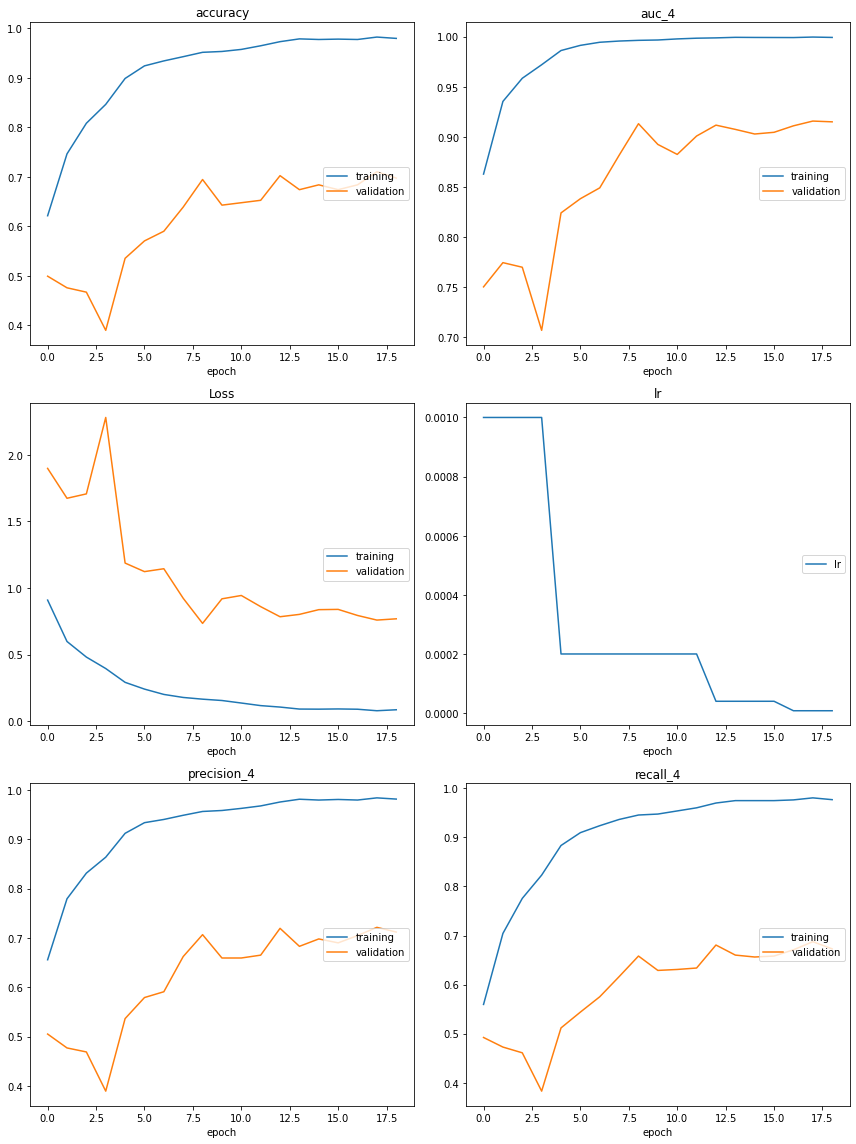

accuracy
	training         	 (min:    0.621, max:    0.982, cur:    0.979)
	validation       	 (min:    0.390, max:    0.710, cur:    0.697)
auc_4
	training         	 (min:    0.863, max:    1.000, cur:    0.999)
	validation       	 (min:    0.707, max:    0.916, cur:    0.915)
Loss
	training         	 (min:    0.078, max:    0.909, cur:    0.086)
	validation       	 (min:    0.734, max:    2.280, cur:    0.768)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
precision_4
	training         	 (min:    0.656, max:    0.984, cur:    0.981)
	validation       	 (min:    0.389, max:    0.721, cur:    0.712)
recall_4
	training         	 (min:    0.560, max:    0.981, cur:    0.977)
	validation       	 (min:    0.383, max:    0.688, cur:    0.673)
128/128 [==============================] - 32s 252ms/step - loss: 0.0856 - accuracy: 0.9795 - precision_4: 0.9813 - recall_4: 0.9770 - auc_4: 0.9992 - val_loss: 0.7683 - val_accuracy: 0.6973 - val_precision_4: 0.7118 - val_recall_

In [26]:
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

optim_2 = Adam(lr=0.001)

vgg_model_ag = create_model(input_shape, n_classes, optim_2, fine_tune=0)

plot_loss_6 = PlotLossesCallback()

# alz_checkpoint_2 = ModelCheckpoint(filepath='Alz_model_v2.best.hdf5',
#                                   save_best_only=True,
#                                   verbose=1)

vgg_ft_history = vgg_model_ag.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[early_stop, reduce_lr, plot_loss_6],
                                  verbose=1)



In [27]:
vgg_preds_ag = vgg_model_ag.predict(testgen)
vgg_pred_classes_ag = np.argmax(vgg_preds_ag, axis=1)

1279/1279 [==============================] - 7s 5ms/step


In [28]:
from sklearn.metrics import accuracy_score

vgg_acc_ag = accuracy_score(true_classes, vgg_pred_classes_ag)
print("Accuracy without Fine-Tuning and with Augmentation: {:.2f}%".format(vgg_acc_ag * 100))

Accuracy without Fine-Tuning and with Augmentation: 64.89%


# **Model with Augmentation and Fine tuning**

In [ ]:
traingen.reset()
validgen.reset()
testgen.reset()

In [9]:
train_generator = ImageDataGenerator(brightness_range=[0.8, 1.2],
                                     horizontal_flip=True, 
                                     fill_mode="constant",
                                     validation_split=0.2,
                                     zoom_range=[.99, 1.01],
                                     rescale=1./255,
                                     preprocessing_function=preprocess_input)

test_generator = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function=preprocess_input)

In [ ]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(img_height, img_width),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=20)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(img_height, img_width),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=20)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(img_height, img_width),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False)

Found 4121 images belonging to 4 classes.
Found 1029 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


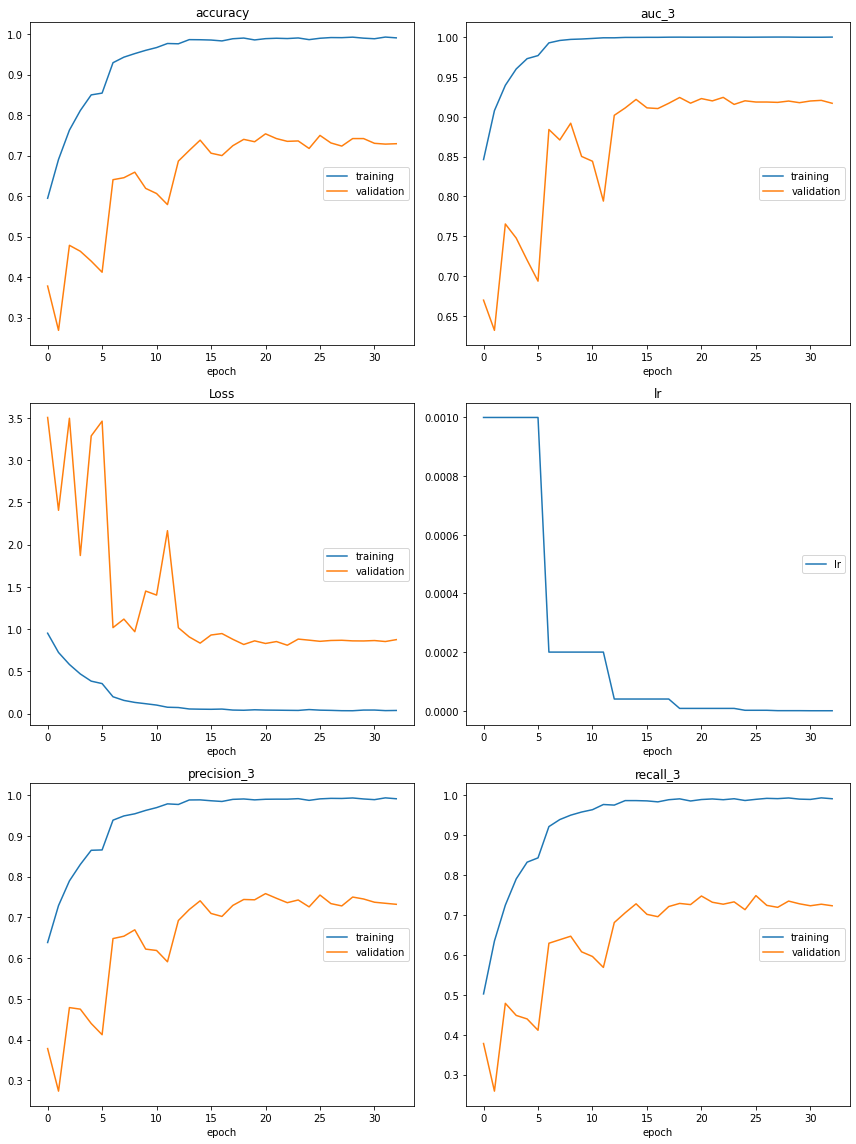

accuracy
	training         	 (min:    0.595, max:    0.993, cur:    0.991)
	validation       	 (min:    0.269, max:    0.754, cur:    0.729)
auc_3
	training         	 (min:    0.846, max:    1.000, cur:    1.000)
	validation       	 (min:    0.632, max:    0.924, cur:    0.917)
Loss
	training         	 (min:    0.034, max:    0.951, cur:    0.037)
	validation       	 (min:    0.809, max:    3.505, cur:    0.875)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
precision_3
	training         	 (min:    0.638, max:    0.993, cur:    0.991)
	validation       	 (min:    0.273, max:    0.758, cur:    0.732)
recall_3
	training         	 (min:    0.502, max:    0.993, cur:    0.990)
	validation       	 (min:    0.259, max:    0.748, cur:    0.723)
128/128 [==============================] - 32s 252ms/step - loss: 0.0367 - accuracy: 0.9910 - precision_3: 0.9909 - recall_3: 0.9905 - auc_3: 0.9999 - val_loss: 0.8752 - val_accuracy: 0.7295 - val_precision_3: 0.7319 - val_recall_

In [18]:
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

optim_2 = Adam(lr=0.001)

vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=1)

plot_loss_2 = PlotLossesCallback()

# alz_checkpoint_2 = ModelCheckpoint(filepath='Alz_model_v2.best.hdf5',
#                                   save_best_only=True,
#                                   verbose=1)

vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[early_stop, reduce_lr, plot_loss_2],
                                  verbose=1)



In [19]:
#vgg_model_ft.load_weights('Alz_model_v2.best.hdf5')

vgg_preds_ft = vgg_model_ft.predict(testgen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

1279/1279 [==============================] - 863s 675ms/step


In [24]:
from sklearn.metrics import accuracy_score

vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("Accuracy with Fine-Tuning and Augmentation: {:.2f}%".format(vgg_acc_ft * 100))

Accuracy with Fine-Tuning and Augmentation: 67.63%


# **Model with Fine tuning 4**

In [ ]:
def create_model(input_shape, n_classes, optimizer, fine_tune=0):
    
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=vgg_model.output_shape[1:]))
    top_model.add(Dense(256))
    top_model.add(BatchNormalization())
    top_model.add(Activation('relu'))
    top_model.add(Dropout(0.2))
    top_model.add(Dense(n_classes, activation='softmax'))

    model = Model(inputs=vgg_model.input, outputs=top_model(vgg_model.output))

    model.trainable = True
    
    if fine_tune > 0:
        fine_tune = (fine_tune * 4) + 1   #fine tuning based number of blocks 
        for layer in model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in model.layers[:19]: #freez all convolution layers
            layer.trainable = False   

    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall() ,tf.keras.metrics.AUC()])
    
    return model

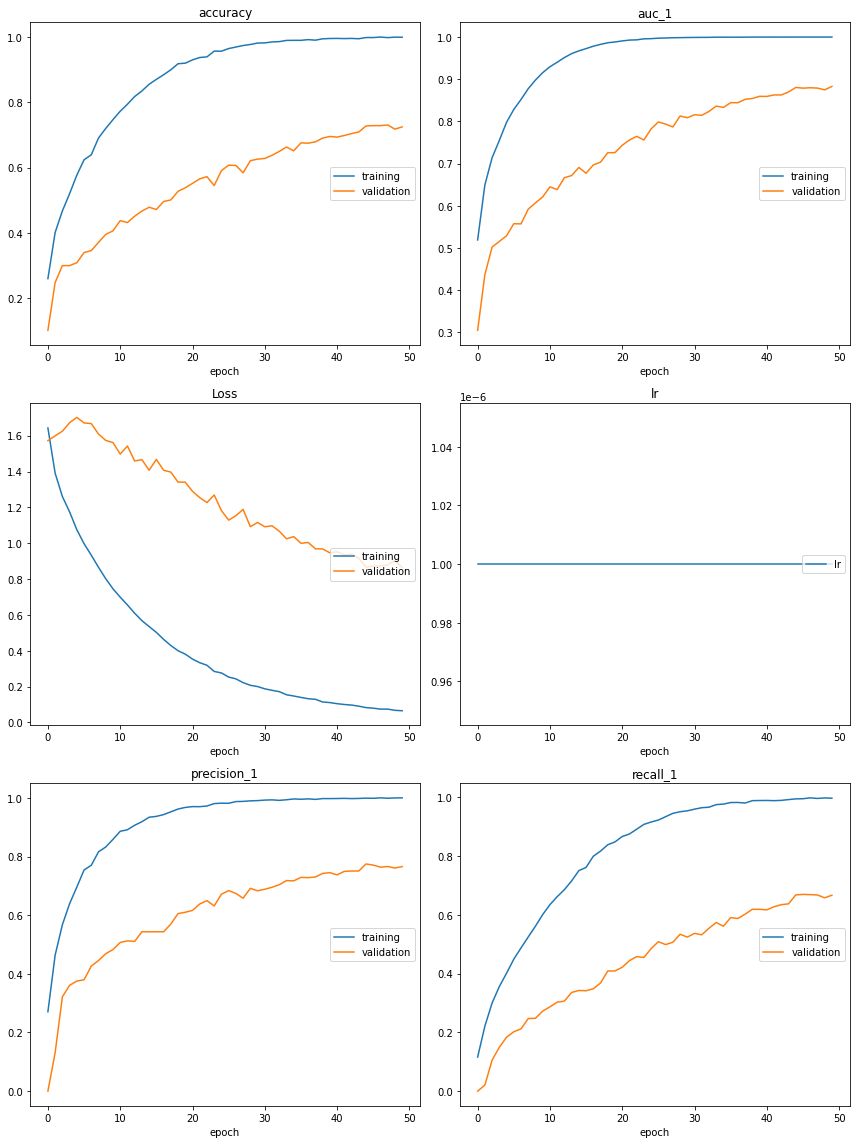

accuracy
	training         	 (min:    0.260, max:    1.000, cur:    0.999)
	validation       	 (min:    0.102, max:    0.730, cur:    0.725)
auc_1
	training         	 (min:    0.519, max:    1.000, cur:    1.000)
	validation       	 (min:    0.305, max:    0.883, cur:    0.883)
Loss
	training         	 (min:    0.065, max:    1.643, cur:    0.065)
	validation       	 (min:    0.864, max:    1.702, cur:    0.864)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
precision_1
	training         	 (min:    0.271, max:    1.000, cur:    1.000)
	validation       	 (min:    0.000, max:    0.775, cur:    0.766)
recall_1
	training         	 (min:    0.116, max:    0.999, cur:    0.997)
	validation       	 (min:    0.000, max:    0.670, cur:    0.667)
128/128 [==============================] - 18s 144ms/step - loss: 0.0653 - accuracy: 0.9993 - precision_1: 1.0000 - recall_1: 0.9973 - auc_1: 1.0000 - val_loss: 0.8643 - val_accuracy: 0.7246 - val_precision_1: 0.7657 - val_recall_

In [ ]:
optim_4 = Adam(lr=0.000001)

vgg_model_ft4 = create_model(input_shape, n_classes, optim_4, fine_tune=4)

plot_loss_4 = PlotLossesCallback()


vgg_ft4_history = vgg_model_ft4.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[early_stop, reduce_lr, plot_loss_4],
                                  verbose=1)



In [ ]:
vgg_preds_ft4 = vgg_model_ft4.predict(testgen)
vgg_pred_classes_ft4 = np.argmax(vgg_preds_ft4, axis=1)

1279/1279 [==============================] - 703s 550ms/step


In [ ]:
from sklearn.metrics import accuracy_score

true_classes = testgen.classes
class_indices = traingen.class_indices
print(class_indices)
class_indices = dict((v,k) for k,v in class_indices.items())
print(class_indices)

vgg_acc_ft4 = accuracy_score(true_classes, vgg_pred_classes_ft4)
print("Accuracy with Fine-Tuning 4 and without Augmentation: {:.2f}%".format(vgg_acc_ft4 * 100))

{'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
{0: 'MildDemented', 1: 'ModerateDemented', 2: 'NonDemented', 3: 'VeryMildDemented'}
Accuracy with Fine-Tuning 4 and without Augmentation: 71.85%
